# DL Assignment 1 - Multi-class Classification with Neural Networks

Welcome to the first assignment of the DL course 2020! In the last homework assignment, you implemented a two layer neural network and trained it for predicting whether or not a flower was displayed in an image.

In this assignment, you will adopt the code in order to classify the type of flower displayed in an image. Hence, you will implement **multi-class classification**. In addition, you will also add another **hidden layer** to the network to see if it can increase the classification accuracy. You will also exchange the sigmoid activations of the hidden layers by **ReLU activations** and **Swish activations**. At last, you will implement **exponential learning rate decay**.

**After completing this assignment, you will have**
- learned to use one-hot encodings and softmax activation for performing multi-class classification.
- computed forward and back propagation computations with more than one hidden layer.
- used the ReLU and Swish activation functions and their derivatives.
- implemented different schedulers learning rate decay.

**After completing this assignment you will**

- Be able to implement **dense** layers 
- Be able to implement **sigmoid**, **ReLU**, and **Swish activation** layers
- Be able to design **Neural Network architectures** containing multiple hidden layers
- Be able to **forward** images through your Neural Network
- Be able to compute the **cross-entropy loss** for measuring the Network's prediction error
- Be able to perform **backpropagation** using the chain rule

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines marked by "<font color='green'>`# TODO`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.

Let's get started!

<font color='darkblue'>
  
**Remember**  
- Run your cells using SHIFT+ENTER (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
</font>

# 0 - Packages
At first, let's import the packages we will need today:

- [numpy](www.numpy.org) remember our first lab: NumPy is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

BTW: Line numbers can be enabled by pressing `CTRL`+`M`+`L`.

# 1 - Obtaining the Image Dataset

Execute the code below for downloading the dataset to `/tmp/multiclass_flowers_64.npz`:

In [2]:
#@title Download Dataset
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('14Gh62sEIynvrhuNzxweHoz2if_ABuZaI', '/tmp/multiclass_flowers_64.npz')

The dataset is provided as archive of numpy arrays, each stored as binary file. We'll unpack them to `X_train, Y_train, X_validation, Y_validation`:

In [3]:
#@title Load and Preprocess Dataset
with np.load('/tmp/multiclass_flowers_64.npz') as data:
    X_train, Y_train, X_validation, Y_validation = [ data[key] for key in ['X_train', 'y_train', 'X_test', 'y_test'] ]

# reshaping
X_train.shape = (X_train.shape[0], np.product( X_train.shape[1:]))
X_train = X_train.T
X_validation.shape = (X_validation.shape[0], np.product( X_validation.shape[1:]))
X_validation = X_validation.T

classes = np.unique(Y_train)
num_classes = len(classes)
print('{} training and {} test samples loaded.'.format(Y_train.size, Y_validation.size))
print('Number of classes: ', num_classes)

450 training and 50 test samples loaded.
Number of classes:  5


There are 5 different classes of flowers. Let's plot some of the images to get an idea about the task:

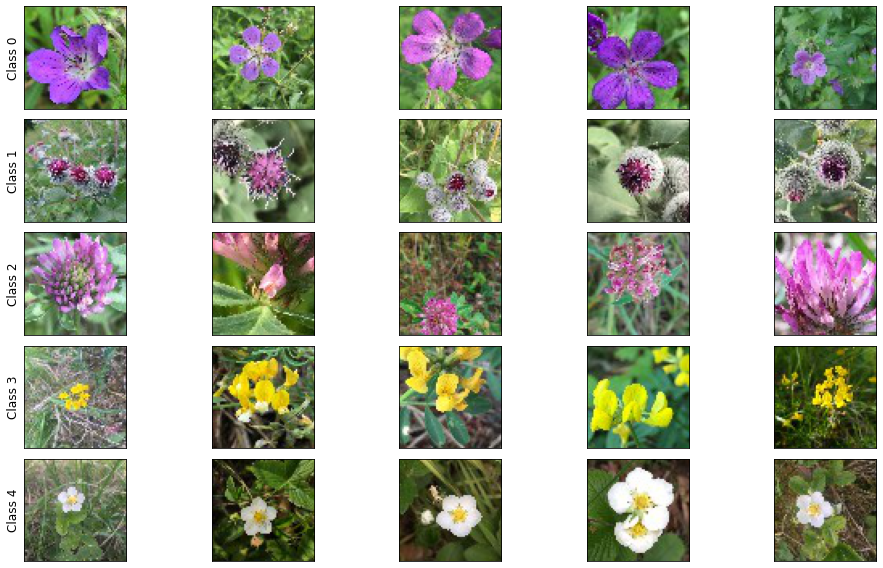

We have 450 training examples
The shape of the variables X_train = (12288, 450) and Y_train = (450,)


In [4]:
#@title Plot Flower Classes
fig, ax = plt.subplots(nrows=num_classes, ncols=5, sharex=True, sharey=True,)
fig.set_size_inches(14, 8)
ax = ax.flatten()
for class_ in range(num_classes):
  ax[num_classes*class_].set_ylabel('Class {}'.format(class_), rotation=90, size='large')
  for sample_ in range(5):
    img = X_train[:, Y_train == class_][:,sample_].reshape(64,64,3) + .5
    ax[num_classes*class_ + sample_].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[num_classes*class_ + sample_].imshow(img)
plt.tight_layout()
plt.show()
print("We have 450 training examples")
print("The shape of the variables X_train = {} and Y_train = {}".format(X_train.shape, Y_train.shape))

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X_train` and `Y_train`? 



# 2 - The Multi-Class Setting
We used the binary classification setting so far. For binary classification on a single sample, our network predicts a scalar value $\hat{y}\in [0,1]$ that can be interpreted as probability of recognizing the positive class.

In the multi-class setting, our network will predict a vector of probabilities, i.e., one probability per class. Every sample will be assigned to exactly one class. Hence, all class probabilities per sample have to sum up to $1$.

In order to setup this multi-class setting, we have to adjust the labels $y$, the activation function for the networks output, as well as the loss function.

## 2.1 - One-hot Encoding of Labels
The input images were already flattened to fit our networks input requirements. However, the target values, i.e., the class labels, are just nominal values. Let's check the class labels of the first 10 training samples:

In [5]:
print(Y_train[:10])

[3 0 2 2 3 3 3 3 1 4]


So, the first image displays a class '3' flower, the second image a class '0' flower and so on. We could predict these target values using a single neuron as output of our network with an activation function different to the sigmoid function. However, this effects an explicit ordering of the classes (e.g., class '3' > class '1'). First of all, such order would be wrong in any case. Secondly, it confuses the network.

Instead, we apply a technique termed "One-hot Encoding" to our target values. One-hot encoding is used to represent categorical values as binary vectors. *One binary row* will be created *for each class label*. The rows will be all zero values except for the index of the true class label. The resulting shape of the one-hot encoded label array will be `(n_classes, n_samples)`.

E.g., the label of the first training image is a `3`. This means that the 4th number (i.e., the number having index 3) in the corresponding one-hot encoded label vector will be `1`. The rest of the vector will be 0.

**Task**: complete the function `onehot()`, which will be used for encoding categorical target values into one-hot representations.

In [6]:
# GRADED FUNCTION: onehot (1 point)
def onehot(y, n_classes):
  '''Encode categorical values into one-hot representation

  Parameters
  ------------
  y : array, shape = (n_samples,)
      True class labels with zero-indexed integer class labels.

  Returns
  ------------
  y_onehot : array, shape = (n_classes, n_samples)
      One-hot encoded true classes labels.
  '''

  ### START YOUR CODE HERE ### (≈3 LOC)
  temp = np.eye(n_classes)[np.array(y).reshape(-1)]
  y_onehot = temp.reshape(list(y.shape)+[n_classes]).T
  
  ### END YOUR CODE HERE ###
  
  return y_onehot

In [7]:
print( onehot(Y_train[:10], 5) )
# expected output: 
#[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
# [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
# [1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Try more examples by yourself to test whether your function `onehot()` is correctly encoding the true labels.

## 2.2 - Class Label Prediction from Vector Outputs
In the binary classification setup discussed in Lab 02, the output layer was constituted of a single neuron. The scalar output $\hat{y}$ of that neuron represented the probability of the input $\vec{x}$ belonging to the positive class. We will use the same idea for multi-class predictions, i.e., using *one output neuron for each class*. Hence, the output layer will yield a vector of class probabilities.

**Task**: Given an output probability array of shape `(num_classes, n_samples)`, your task is to predict per sample the index of the highest probability.

**Hint**: use the `np.argmax()` function.

In [8]:
# GRADED FUNCTION: predict_multiclass (1 point)
def predict_multiclass(A_out):
  '''Predict class indices from output probabilities.
    
  Parameters
  ------------
  A_out : array, shape = (num_classes, n_samples)
      Output of last layer.
      
  Returns
  ---------
  y_prediction : array, shape = (n_samples)
      Predicted class indices.
  '''

  ### START YOUR CODE HERE ### (≈1 LOC)
  y_prediction = np.argmax(A_out, axis=0)
  ### END YOUR CODE HERE ###

  return y_prediction

In [9]:
print( predict_multiclass(np.array([[ 0,  0, .8, .7, .1], 
                                    [.9, .2,  0, .2, .6], 
                                    [.1, .8, .2, .1, .3]])))
# expected output: [1 2 0 0 1]

[1 2 0 0 1]


## 2.3 - Softmax activation

We will use the *softmax* function to convert the output of the last layer into probabilities that sum to one. The softmax function outputs a vector that represents the categorical probability distributions across the list of target classes. 

The softmax function is defined as

$\large S = \frac{e^{Z_j}}{\sum_j^K e^{Z_j}}$,

where $Z$ is the array of outputs of the last layer and $K$ is the number of classes.

**Task**: Implement the softmax function.

In [10]:
# GRADED FUNCTION: softmax (1 point)
def softmax(Z):
  '''Computes the softmax for each column of `Z`.
  
  Your code should work for a vector as well as for matrices of shape (n_output, n_samples).

  Argument
  ----------
  Z : np.array()
      A numpy matrix of shape (n_output, n_samples)

  Returns
  ---------
  S : np.array, shape = (n_output, n_samples)
      Softmax of input.
  '''
  
  ### START YOUR CODE HERE ###  (≈1 LOC)
  S = np.exp(Z) / np.sum(np.exp(Z), axis=0)
  ### End YOUR CODE HERE ###

  return S

In [11]:
print(softmax( np.array([[-3.3,  3.57,  0.9],
                         [-0.3,  0.96,  1.4],
                         [-0.2,  1.40,  1.7],
                         [ 2.5, -4.63, -1.9],
                         [-0.2, -0.82, -3.0]]) ).sum(axis=0))
# expected output: [1. 1. 1.]

[1. 1. 1.]


## 2.4 - Cross-entropy Loss

For measuring the error of our model, we need to compare the predicted class probability vectors in $\hat{Y}$ to the one-hot encoded class label vectors in $Y$. For binary classification, we used the binary cross-entropy loss. Here, we will use the **cross-entropy loss** in it's generalized form:

$\large l = - \sum_{j=1}^{K} y_j \log (\hat{y}_j)$,

where $j \in [1, \ldots, K]$ iterates over the $K$ classes. 

Remember that we take the average loss across all $m_\mathrm{batch}$ samples in a minibatch:

$\large \mathcal{L} = - \frac{1}{m_\mathrm{batch}}\sum_{i=1}^{m_\mathrm{batch}} \sum_{j=1}^{K} y_{j,i} \log (\hat{y}_{j,i})$.

In [12]:
# GRADED FUNCTION: cross_entropy_loss (1 point)
def cross_entropy_loss(Y, Y_hat):
  ''' Return multi-class cross-entropy loss and its gradient w.r.t. `Y_hat`

  Arguments:
  ---
    Y : One-hot encoded ground truth data labels (expected labels)
    Y_hat : Predicted labels (output of last layer)

  Returns:
  ---
    loss : value of the cross-entropy loss
    dY_hat : gradient of cross-entropy loss w.r.t. Y_hat
  '''
  # prevent log(0)
  Y_hat += 1e-9

  # cross entropy loss
  ### START YOUR CODE HERE ###  (≈1 LOC)
  loss  = -np.mean(np.sum(Y * np.log(Y_hat), axis = 0))
  ### END YOUR CODE HERE ###

  # cross entropy derivative
  dY_hat = (Y_hat - Y) / (Y_hat * (1 - Y_hat))

  return loss, dY_hat

# 3 - Implement Layers

Your network will contain dense layers and different activation layers. We objectify these layers for making the forward and backward computations easier. In detail, each layer class will have a `forward` and `backward` method that are callable on arbitrary inputs of defined shape.

**Task**: The code below contains several <font color='green'>`# TODO`</font>s. Your task is to complete the code.

## 3.1 - Dense (fully-connected) Layer 

In [13]:
# GRADED CLASS: Dense (4 points)
class Dense:
  ''' Dense layer with weight matrix `W` and bias vector `b`
  
  Arguments:
  ---
    neurons : number of neurons in layer; equal to output dimension of layer
    input_shape : shape of input data (num_samples, num_features)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
    update( learning_rate )
  '''

  def __init__(self, neurons, input_shape):

    self.input_shape = input_shape
    self.neurons = neurons

    # initialize using Xavier init
    self.W = np.random.randn(self.neurons, self.input_shape[0]) * np.sqrt(2/(self.input_shape[0]+self.neurons))
    self.b = np.zeros( (self.neurons, 1) )

    # allocate output (neurons, m)
    self.Z_out = np.zeros( (self.neurons, self.input_shape[1]))


  def forward(self, A_in):
    ''' Forward pass of `A_in` through dense layer. Output is stored in `Z_out`. '''
    
    # store layer input
    self.A_in = A_in 
    
    # compute layer output
    ### START YOUR CODE HERE ###  (≈1 LOC)
    self.Z_out = np.dot(self.W , self.A_in) + self.b
    ### END YOUR CODE HERE ###


  def backward(self, gradient):
    ''' Backward pass of `gradient` through dense layer. Outputs are stored in `dW`, `db`, `dA_in`. '''

    # derivative w.r.t. `W`
    ### START YOUR CODE HERE ###  (≈1 LOC)
    self.dW = np.dot(gradient, self.A_in.T)
    ### END YOUR CODE HERE ###

    # derivative w.r.t. `b`
    self.db = np.sum(gradient, axis=1, keepdims=True)

    # derivative w.r.t. `A_in`
    self.dA_in = np.dot(self.W.T, gradient)


  def update(self, learning_rate):
    ''' Update layer parameters `W`, `b` using `learning_rate` '''

    ### START YOUR CODE HERE ### (≈2 LOC)
    self.W = self.W - learning_rate * self.dW
    self.b = self.b - learning_rate * self.db
    ### END YOUR CODE HERE ###

## 3.2 - Activation layers

Complete the `forward` and `backward` methods of the `Sigmoid` class:

In [14]:
# GRADED CLASS: Sigmoid (2 points)
class Sigmoid:
  ''' Activation layer using the logistic function (aka sigmoid function)
  
  Arguments:
  ---
    input_shape : shape of input data (num_samples, num_features)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
  '''

  def __init__(self, input_shape):
    # allocate output
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    ''' Forward pass of `Z_in`: compute sigmoid activation. Output is stored in `A_out`. '''
    ### START YOUR CODE HERE ###  (≈1 LOC)
    self.A_out =1/(1+np.exp(-Z_in))
    ### END YOUR CODE HERE ###

  def backward(self, gradient):
    ''' Backward pass of `gradient` through sigmoid layer. Output is stored in `dZ`. '''
    ### START YOUR CODE HERE ###  (≈1 LOC)
    self.dZ = gradient * self.A_out * (1 - self.A_out)
    ### END YOUR CODE HERE ###

The `Softmax` class uses your `softmax` function defined above:

In [15]:
class Softmax:
  ''' Softmax activation layer
  
  Arguments:
  ---
    input_shape : shape of input data (num_samples, num_features)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
  '''
  def __init__(self, input_shape):
    # allocate output
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    ''' Forward pass of `Z_in`: compute softmax activation. Output is stored in `A_out`. '''
    # Subtract maximum in `Z_in` for better numerical stability
    Z_in -= np.max(Z_in)
    # Compute softmax (using your definition from above)
    self.A_out = softmax(Z_in)

  def backward(self, gradient):
    ''' Backward pass of `gradient` through softmax layer. Output is stored in `dZ`. '''
    t1 = np.einsum('ji,ki->ijk', self.A_out, self.A_out)
    t2 = np.einsum('ji,kj->ijk', self.A_out, np.eye(self.A_out.shape[0], self.A_out.shape[0]))
    dS = t2-t1
    self.dZ = np.einsum('ijk,ki->ji', dS, gradient)

# 4 - Learning Rate Schedules

As discussed in the lecture, we typically decrease the learning rate $\eta$ as training progresses. Here, you'll implement and use different learning rate schedules for that.

### 4.1 - Inverse Decay
In inverse decay, the learning rate is reduced based on the inverse of elapsed time. The mathematical form is:

$\large \eta = \frac{\eta_0}{1 + d \cdot t}$,

with the initial learning rate $\eta_0$, decay parameter $d$ and number of elapsed epochs $t$.

In [16]:
# GRADED FUNCTION: lr_inverse_decay (1 point)
def lr_inverse_decay(lr0, epoch, decay=.01):
  '''Learning rate schedule for inverse decay.
  
  Arguments
  ----------
  lr0 : initial learning rate
  epoch : number of epochs elapsed
  decay : decay parameter (defaults to .5)

  Returns
  ---------
  lr : learning rate computed using inverse decay
  '''
  ### START YOUR CODE HERE ###  (≈1 LOC)
  lr = lr0/(1+decay*epoch)
  ### END YOUR CODE HERE ###
  return lr

### 4.2 - Step Decay
In step decay, the learning rate is reduced by a predefined value every defined number of epochs. A typical setting is to reduce learning rate by 90% every 10 epochs:

In [17]:
def lr_step_decay(lr0, epoch, drop=.9, drop_epochs=10):
  '''Learning rate schedule for step decay.
  
  Arguments
  ----------
  lr0 : initial learning rate
  epoch : number of epochs elapsed
  drop : decay parameter (defaults to .5)
  drop_epochs : reduce learning rate every `drop_epochs` epochs (defaults to 10)

  Returns
  ---------
  lr : learning rate computed using step decay
  '''
  return lr0 * np.power(drop, np.floor(epoch/drop_epochs))

### 4.3 - Exponential Decay
Exponential decay reduces the learning rate following an exponential curve:

$\large \eta = \eta_0 \exp^{- d \cdot t}$,

with the initial learning rate $\eta_0$, decay parameter $d$ and number of elapsed epochs $t$.

In [18]:
# GRADED FUNCTION: lr_exponential_decay (1 point)
def lr_exponential_decay(lr0, epoch, decay=.01):
  '''Learning rate schedule using exponential decay.
  
  Arguments
  ----------
  lr0 : initial learning rate
  epoch : number of epochs elapsed
  decay : decay parameter (defaults to .05)

  Returns
  ---------
  lr : learning rate computed using step decay
  '''
  ### START YOUR CODE HERE ###  (≈1 LOC)
  lr = lr0 * np.exp(-decay*epoch)
  ### END YOUR CODE HERE ###
  return lr

Execute the cell below for visualization of the different learning rate schedules.

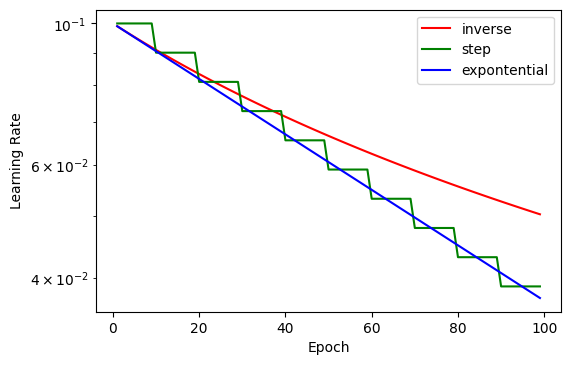

In [19]:
#@title plot learning rate schedules
lr0 = 1e-1
epochs=np.arange(1,100, 1)

plt.figure(dpi=100)
plt.plot(epochs, lr_inverse_decay(lr0, epochs), 
         color='red', label='inverse')
plt.plot(epochs, lr_step_decay(lr0, epochs), 
         color='green', label='step')
plt.plot(epochs, lr_exponential_decay(lr0, epochs), 
         color='blue', label='expontential')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

# 5 - Implementing a 2 Layer Neural Network

Using the layers, loss function, and learning rate schedules defined above, we can now implement our neural network.

In [20]:
# GRADED CLASS: NeuralNet (1 point)
class NeuralNet:
  ''' Feed-forward neural network with two layers

  Arguments:
  ---
  input_shape : shape of input data
  num_classes : number of classes
  batch_size : batch size (default=100)
  init_lr : initial learning rate (default=1e-3)
  lr_scheduler : learning rate scheduler (default=lr_step_decay)
  shuffle : shuffle data during training (default=True)
  verbose : print stats after each epoch (default=True)
  
  Methods:
  ---
  fit
  predict
  '''

  def __init__(self, input_shape, num_classes, 
               batch_size=100, 
               init_lr=1e-3,
               lr_scheduler=lr_step_decay, 
               shuffle=True,
               seed=42,
               verbose=True):
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.batch_size = batch_size
    self.init_lr = init_lr
    assert lr_scheduler in (None, lr_step_decay, lr_inverse_decay, lr_exponential_decay), 'Unknown learning rate scheduler'
    self.lr_scheduler = lr_scheduler
    self.shuffle = shuffle
    self.random = np.random.RandomState(seed)
    self.verbose = verbose
    self.set_architecture()
    if self.verbose:
      print('Initialized Neural Network with {} parameters.'.format(self.number_of_parameters))


  def set_architecture(self):

    # hidden layer with 10 neurons
    self.Z1 = Dense(10,
                    (self.input_shape[0], self.batch_size))
    # sigmoid activation of hidden layer output
    self.A1 = Sigmoid(self.Z1.Z_out.shape)

    # output layer with `num_classes` neurons
    self.Z2 = Dense(self.num_classes,
                    self.A1.A_out.shape)
    # softmax activation of output layer
    self.A2 = Softmax(self.Z2.Z_out.shape)


  @property    
  def get_params(self):
    self._params_list = list()
    i=1
    while hasattr(self, 'Z{}'.format(i)):
      param = getattr(self, 'Z{}'.format(i))
      self._params_list.append( param.W )
      self._params_list.append( param.b )
      i += 1
    return self._params_list

  @property
  def number_of_parameters(self):
    self._number_of_parameters = np.sum(
        [param.size for param in self.get_params]
          )
    return self._number_of_parameters

  def _forward(self, X):
    ''' Propagate input `X` through network. Return output of last layer. '''
    self.Z1.forward(X)
    self.A1.forward(self.Z1.Z_out)
    self.Z2.forward(self.A1.A_out)
    self.A2.forward(self.Z2.Z_out)
    return self.A2.A_out

  def _backprop(self, dA_out):
    ''' backpropagate gradient `dA_out` w.r.t. predicted output through the network. '''
    self.A2.backward(dA_out)
    self.Z2.backward(self.A2.dZ)
    self.A1.backward(self.Z2.dA_in)
    self.Z1.backward(self.A1.dZ)

  def _update(self, learning_rate):
    ### START YOUR CODE HERE ### (≈2 LOC)
    self.Z2.update(learning_rate)
    self.Z1.update(learning_rate)
    ### END YOUR CODE HERE ###

  def predict(self, X):
    ''' Predict label index of X
    
    Arguments:
    ---
    X : Array of input features; shape = (n_features, m)
    '''
    Y_hat = self._forward(X)
    return predict_multiclass( Y_hat )

  def fit(self, X_train, Y_train, X_validation, Y_validation, epochs):
    ''' Train on training data, validate on validation data

    Arguments:
    ---
    X_train : input training data
    Y_train : training data class labels
    X_validation : input validation data
    Y_validation : validation data class labels
    epochs : number of epochs to train
    '''

    train_steps = X_train.shape[1] / self.batch_size

    print()
    epoch_strlen = len(str(epochs))

    history = {'loss':list(), 'val_loss':list(),
               'train_acc':list(), 'val_acc':list(), 
               'learning_rate':list()}
    epoch_stats = {'loss':0, 'val_loss':0, 'train_acc':0, 'val_acc':0}

    lr = self.init_lr

    # iterate over training epochs
    for epoch in range(epochs):

      if self.lr_scheduler:
        # adjust learning rate
        lr = self.lr_scheduler(self.init_lr, epoch)

      # iterate over minibatches
      indices = np.arange( X_train.shape[1] )

      if self.shuffle:
        self.random.shuffle(indices)

      for start_idx in range(0, indices.shape[0] - self.batch_size + 1, self.batch_size):
        batch_indices = indices[start_idx:start_idx + self.batch_size]
        
        # forward propagate batch of samples
        Y_hat = self._forward(X_train[:, batch_indices])
        epoch_stats['train_acc'] += np.sum( predict_multiclass(Y_hat) == Y_train[batch_indices])

        # compute loss and gradient
        loss, dAout = cross_entropy_loss(onehot(Y_train[batch_indices], self.num_classes), Y_hat)
        epoch_stats['loss'] += loss

        # backpropagate gradient
        self._backprop(dAout)

        # update weights
        self._update( lr )
      
      epoch_stats['loss'] /= train_steps
      epoch_stats['train_acc'] /= (train_steps * self.batch_size)

      # eval on validation split after each epoch
      Y_validation_Aout = self._forward(X_validation)
      val_loss, _ = cross_entropy_loss( onehot(Y_validation, self.num_classes), Y_validation_Aout )
      epoch_stats['val_loss'] = val_loss

      Y_validation_hat = predict_multiclass (Y_validation_Aout )
      epoch_stats['val_acc'] = np.mean(Y_validation_hat == Y_validation)

      if self.verbose:
        sys.stderr.write('\rProgress: {}/{} | '.format(epoch+1, epochs) + \
                        'Loss: {:.2g} | '.format(epoch_stats['loss']) + \
                        'validation loss: {:.2g} | '.format(epoch_stats['val_loss']) + \
                        'train accuracy: {:.2f}% | '.format(epoch_stats['train_acc']*100) + \
                        'validation accuracy: {:.2f}% '.format(epoch_stats['val_acc']*100) + \
                        'learning rate: {:.2e}'.format(lr)
                        )
      
        #sys.stderr.flush()

      # store history
      history['loss'].append(epoch_stats['loss'])
      history['val_loss'].append(epoch_stats['val_loss'])
      history['train_acc'].append(epoch_stats['train_acc'])
      history['val_acc'].append(epoch_stats['val_acc'])
      history['learning_rate'].append(lr)

    return history

## 5.1 - Testing the Forward Computation

Now it's time to initialize the network and test the forward propagation.

Let's define some hyperparameters and create an instance of our `NeuralNet`:

In [21]:
# Hyperparameters
BATCHSIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
NUM_CLASSES = len(np.unique(Y_train))

In [22]:
my_NN = NeuralNet(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_step_decay,
                  )

Initialized Neural Network with 122945 parameters.


The layers were initialized with normal distributed random weights. Hence, the untrained network will return random predictions.
The validation split is balanced, i.e., it contains the same amount of for all classes. For multi-class classification on balanced data, random guessing should return an accuracy of roughly 20%:

In [23]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 18.0%


## 5.2 - Training and Evaluation

Now it's time to finally train your network. 

Train it for 100 epochs with a minibatch size of 100 using the `.fit()` method. If your implementation is correct, you should achieve a classification accuracy >70% on the validation data:

In [24]:
history = my_NN.fit(X_train, Y_train,
                    X_validation, Y_validation, 
                    NUM_EPOCHS
                    )

Progress: 100/100 | Loss: 0.12 | validation loss: 0.54 | train accuracy: 88.86% | validation accuracy: 78.00% learning rate: 3.87e-04

We can again call the `.predict()` method on the validation data again and see how the network improved:

In [25]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 78.0%


In addition, we stored the loss as well the training and validation accuracy of the network after each epoch in the `history` dictionary. Let's plot the learning curve, i.e., the loss over epochs, and the accuracies:

In [26]:
#@title Definition: `plot_history( history )`
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history['loss'], label='training')
  ax1.plot(history['val_loss'], label='validation', linestyle='--')
  ax1.set_ylabel('Binary CE Loss')
  ax1b = ax1.twinx()
  ax1b.plot(history['learning_rate'], 'g-', linewidth=1)
  ax1b.set_yscale('log')
  ax1b.set_ylabel('Learning Rate', color='g')
  
  ax2.plot(history['train_acc'], label='training')
  ax2.plot(history['val_acc'], label='validation', linestyle='--')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

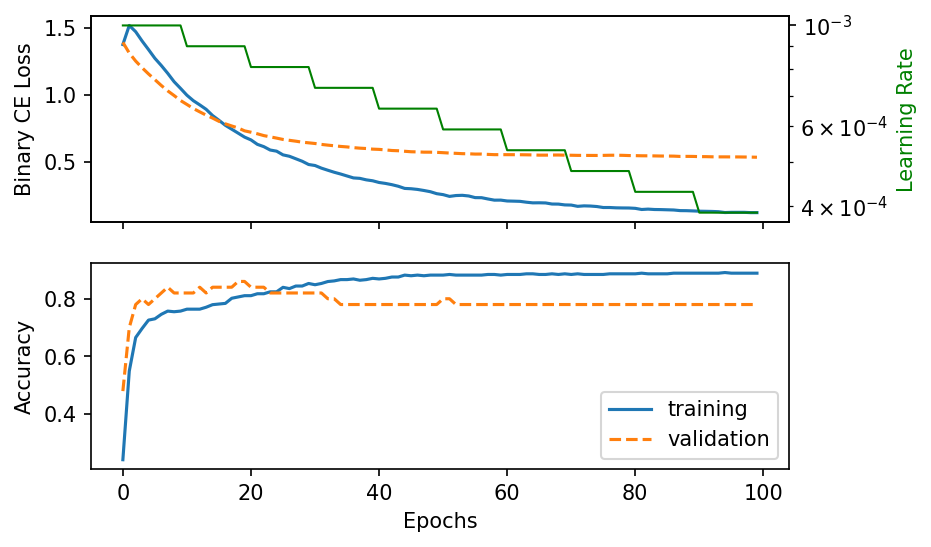

In [27]:
plot_history(history)

## 5.3 - Comparison of Learning Rate Schedules
Execute the cell below for running 5 experiments per learning rate schedule and plotting the results.

Learning rate schedule: constant
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_step_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_inverse_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_exponential_decay
run 0

run 1

run 2

run 3

run 4



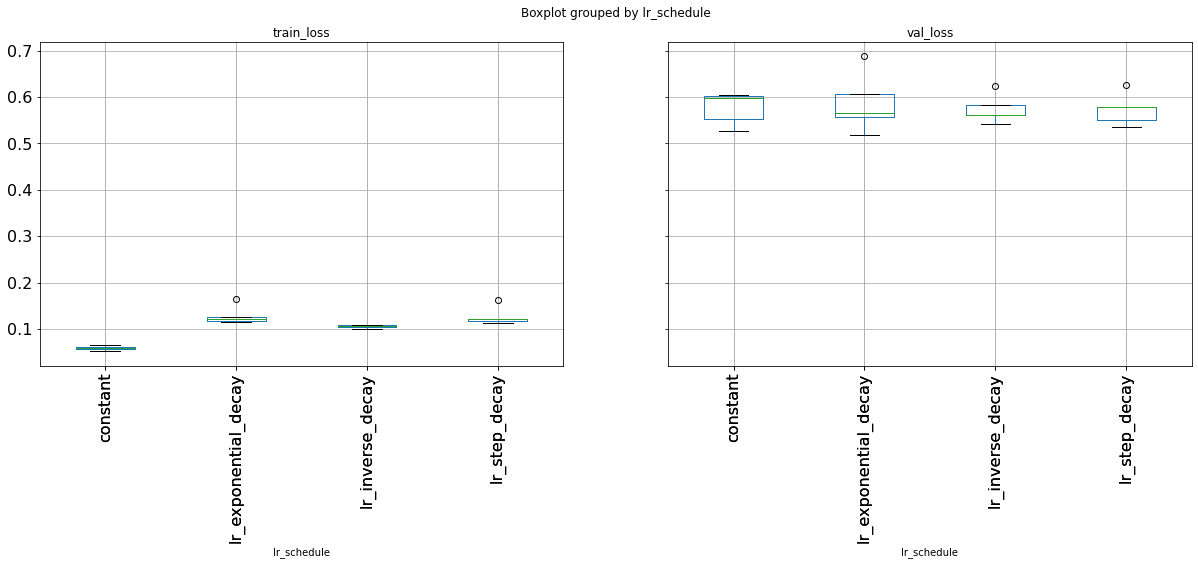

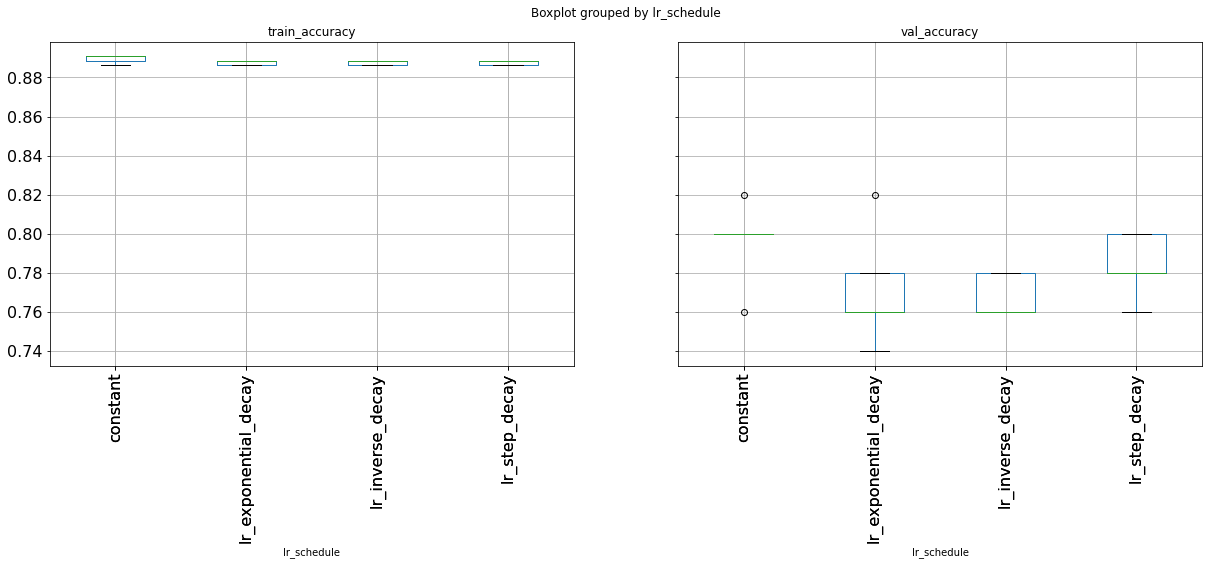

In [28]:
#@title run experiments and plot results

import pandas as pd

results = pd.DataFrame(columns=['lr_schedule', 'repetition', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for lr_schedule in (None, lr_step_decay, lr_inverse_decay, lr_exponential_decay):
  print('Learning rate schedule:', lr_schedule.__name__ if lr_schedule else 'constant')
  for repetition in range(5):
    print('run', repetition)
    my_NN = NeuralNet(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_schedule,
                  verbose=False
                  )
    history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)
    run_results = [lr_schedule.__name__ if lr_schedule else 'constant', 
                   repetition,
                   history['loss'][-1],
                   history['val_loss'][-1],
                   history['train_acc'][-1],
                   history['val_acc'][-1],
                   ]
    results.loc[len(results)] = run_results

axes = results.boxplot(column=['train_loss', 'val_loss'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

axes = results.boxplot(column=['train_accuracy', 'val_accuracy'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

# 6 - Increasing the Networks Depth

We may achieve an accuracy of ≈80% using our 2 layer neural network. Let's see if we can increase the accuracy by adding **two more hidden layers**, each having 10 neurons!

In order to add more hidden layers, you need to adjust the

- `set_architecture()`
- `_forward()`
- `_backprop()`
- `_update()`

methods of the `DeepNeuralNet` class below.

In [29]:
# GRADED CLASS: DeepNeuralNet (4 points)
class DeepNeuralNet(NeuralNet):
  '''Feed-forward neural network with 3 hidden layers. Inherits from `NeuralNet`. '''

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    '''Define the architecture: 3 hidden layers with 10 neurons and sigmoid activation.
    The output layer has `num_classes` neurons with softmax activation.'''
    ### START YOUR CODE HERE ### (≈8 LOC)
    # first hidden layer with 10 neurons
    self.Z1 = Dense(10, (self.input_shape[0], self.batch_size))
    # sigmoid activation of hidden layer output
    self.A1 = Sigmoid(self.Z1.Z_out.shape)

    # second hidden layer with 10 neurons
    self.Z2 = Dense(10, self.A1.A_out.shape)
    # sigmoid activation of hidden layer output
    self.A2 = Sigmoid(self.Z2.Z_out.shape)

    # third hidden layer with 10 neurons
    self.Z3 = Dense(10,
                    self.A2.A_out.shape)
    # sigmoid activation of hidden layer output
    self.A3 = Sigmoid(self.Z3.Z_out.shape)

    # output layer with `num_classes` neurons
    self.Z4 = Dense(self.num_classes,
                    self.A3.A_out.shape)
    # softmax activation of output layer
    self.A4 = Sigmoid(self.Z4.Z_out.shape)
    ### END YOUR CODE HERE ###

  def _forward(self, X):
    ''' Propagate input `X` through network. Return output of last layer. '''
    ### START YOUR CODE HERE ### (≈8 LOC)
    self.Z1.forward(X)
    self.A1.forward(self.Z1.Z_out)
    self.Z2.forward(self.A1.A_out)
    self.A2.forward(self.Z2.Z_out)
    self.Z3.forward(self.A2.A_out)
    self.A3.forward(self.Z3.Z_out)
    self.Z4.forward(self.A3.A_out)
    self.A4.forward(self.Z4.Z_out)
    ### END YOUR CODE HERE ###
    return self.A4.A_out

  def _backprop(self, dA_out):
    ''' Backpropagate gradient `dA_out` w.r.t. predicted output through the network. '''
    ### START YOUR CODE HERE ### (≈8 LOC)
    self.A4.backward(dA_out)
    self.Z4.backward(self.A4.dZ)
    self.A3.backward(self.Z4.dA_in)
    self.Z3.backward(self.A3.dZ)
    self.A2.backward(self.Z3.dA_in)
    self.Z2.backward(self.A2.dZ)
    self.A1.backward(self.Z2.dA_in)
    self.Z1.backward(self.A1.dZ)
    ### END YOUR CODE HERE ###

  def _update(self, learning_rate):
    ### START YOUR CODE HERE ### (≈4 LOC)
    self.Z4.update(learning_rate)
    self.Z3.update(learning_rate)
    self.Z2.update(learning_rate)
    self.Z1.update(learning_rate)
    ### END YOUR CODE HERE ###

## 6.1 - Training and Evaluation

Init an instance of the `DeepNeuralNet` and train for 100 epochs:

Initialized Neural Network with 123165 parameters.



Progress: 100/100 | Loss: 1.8 | validation loss: 1.6 | train accuracy: 53.89% | validation accuracy: 58.00% learning rate: 3.87e-04

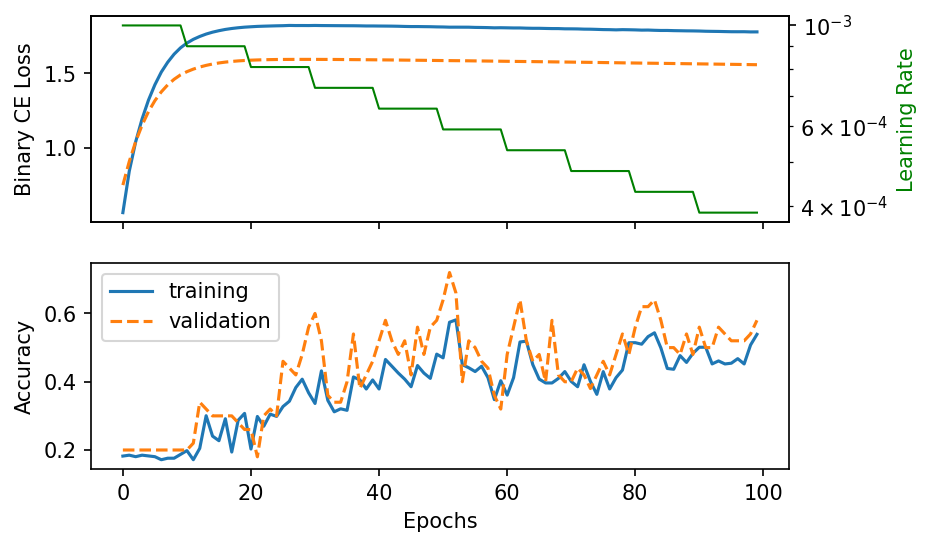

In [30]:
my_DNN = DeepNeuralNet(X_train.shape,
                       NUM_CLASSES,
                       batch_size=BATCHSIZE,
                       init_lr=LEARNING_RATE,
                       lr_scheduler=lr_step_decay,
                       )

history = my_DNN.fit(X_train, Y_train,
                     X_validation, Y_validation, 
                     NUM_EPOCHS
                     )

plot_history(history)

What happened? SGD is having a hard time finding an optimum for your deep network. Reason are the small gradients of the sigmoid function:

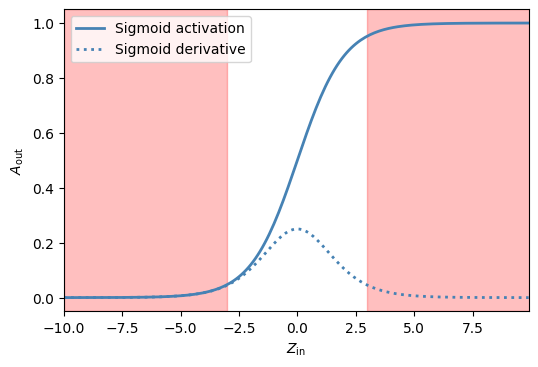

In [31]:
#@title plot sigmoid activation and derivative
z_in = np.arange(-10, 10, .1)
_sigmoid = Sigmoid(z_in.shape)
_sigmoid.forward(z_in)
_sigmoid.backward(1)
plt.figure(dpi=100)
plt.plot(z_in, _sigmoid.A_out, 
         color='steelblue', 
         linewidth=2,
         label='Sigmoid activation'
         )
plt.plot(z_in, _sigmoid.dZ, 
         color='steelblue', 
         linewidth=2,
         linestyle=':',
         label='Sigmoid derivative'
         )
plt.axvspan(-10, -3, color='red', alpha=0.25)
plt.axvspan(3, 10, color='red', alpha=0.25)
plt.xlim((np.min(z_in), np.max(z_in)))
plt.xlabel(r'$Z_\mathrm{in}$')
plt.ylabel(r'$A_\mathrm{out}$')
plt.legend()
plt.show()

A problem with the sigmoid (and $\tanh$) activation function is their flatness for small and large input values. In addition, the value for the sigmoid derivative is always notably smaller than $1$. In fact, the maximum of the derivative is $0.25$. If we backpropagate gradients through a series of sigmoid layers, the gradients become smaller and smaller by being multiplied to values $\leq 0.25 $, quickly resulting in **vanishing gradients**.

## 6.2 - ReLU and Swish Activation Functions

The **ReLU** (Rectified Linear Unit) activation, defined as 

$\mathrm{ReLU}(z) = max(0, z)$.

is far better suited for Deep Learning with many layers. First of all, it is more computationally efficient compared to the sigmoid function. In addition, the derivative of the ReLU function

$\frac{d}{dz} \mathrm{ReLU}(z) = \begin{cases} 
0 & \text{if  }  z \leq 0 \\
1 & \text{if  }  z > 0 \\
\end{cases}$

is either $0$ or $1$. Hence, you can stack much more layers without decreasing the gradient magnitudes.

In [32]:
# GRADED FUNCTION: ReLU (2 points)
class ReLU:
  ''' Rectified linear unit activation layer
  
  Arguments:
  ---
    input_shape : shape of input data (num_samples, num_features)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
  '''

  def __init__(self, input_shape):
    # allocate output
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    ''' Forward pass of `Z_in`: compute ReLU activation. Output is stored in `A_out`. '''
    ### START YOUR CODE HERE ### (≈1 LOC)
    self.A_out = np.maximum(0,Z_in)
    ### END YOUR CODE HERE ###

  def backward(self, gradient):
    ''' Backward pass of `gradient` through ReLU layer. Output is stored in `dZ`. '''
    ### START YOUR CODE HERE ### (≈1 LOC)
    self.dZ = gradient * ( self.A_out > 0)
    ### END YOUR CODE HERE ###

Also the ReLU function can have a disadvantage: if an activation is below $0$ the gradient will be $0$ too. Hence, neurons with $0$ ReLU activation won't get updated. On one hand this can be beneficial, as not all neurons get activated and the output will be sparse, which can save computations and be more efficient. On the other hand, if these activations are below $0$ for all inputs, the neurons generally won't update during Gradient Descent, causing the **dying ReLU** problem which ultimately decreases a networks's capacity.

This dying ReLU problem can be mitigated, e.g., by assigning a small positive slope for $z<0$ which is termed as **leaky ReLU**. However, another nice solution is the so called [**Swish** activation function](https://arxiv.org/abs/1710.05941):

$\large \mathrm{Swish}(z) = z \cdot \sigma(\beta z) = \frac{z}{1+ \exp^{-\beta z}}$,

with the either constant or trainable parameter $\beta$. Implement the Swish function below and see for yourself:

In [33]:
# GRADED FUNCTION: Swish (1 point)
class Swish:
  ''' Swish activation layer
  
  Arguments:
  ---
    input_shape : shape of input data (num_samples, num_features)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
  '''

  def __init__(self, input_shape, beta=1.):
    # allocate output
    self.A_out = np.zeros( input_shape )
    self._beta = beta

  def forward(self, Z_in):
    ''' Forward pass of `Z_in`: compute Swish activation. Output is stored in `A_out`. '''
    self.Z_in = Z_in
    ### START YOUR CODE HERE ### (≈1 LOC)
    self.A_out = self.Z_in / (1 + np.exp(-self._beta * self.Z_in))
    ### END YOUR CODE HERE ###

  def backward(self, gradient):
    ''' Backward pass of `gradient` through Swish layer. Output is stored in `dZ`. '''
    self.dZ = gradient * ( self._beta * self.A_out + 1/(1+np.exp(-self._beta * self.Z_in)) * (1 - self._beta * self.A_out))

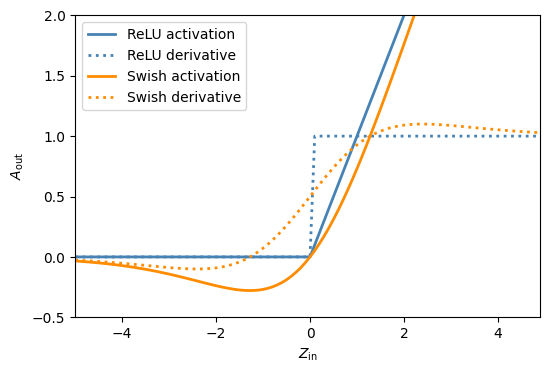

In [34]:
#@title plot ReLU and Swish activation and derivative
z_in = np.arange(-5, 5, .1)
_relu = ReLU(z_in.shape)
_relu.forward(z_in)
_relu.backward(1)
_swish = Swish(z_in.shape)
_swish.forward(z_in)
_swish.backward(1)
plt.figure(dpi=100)
plt.plot(z_in, _relu.A_out, 
         color='steelblue',
         linewidth=2,
         label='ReLU activation'
         )
plt.plot(z_in, _relu.dZ, 
         color='steelblue',
         linewidth=2,
         linestyle=':',
         label='ReLU derivative'
         )
plt.plot(z_in, _swish.A_out, 
         color='darkorange',
         linewidth=2, 
         label='Swish activation'
         )
plt.plot(z_in, _swish.dZ, 
         color='darkorange',
         linewidth=2,
         linestyle=':',
         label='Swish derivative'
         )
plt.xlim((np.min(z_in), np.max(z_in)))
plt.ylim((-.5, 2))
plt.xlabel(r'$Z_\mathrm{in}$')
plt.ylabel(r'$A_\mathrm{out}$')
plt.legend()
plt.show()

## 6.3 - DeepNeuralNet with Swish Activation

**Task:** Below is a copy of your `DeepNeuralNet`. Replace the `Sigmoid` activations in `DeepNeuralNet_Swish` with `Swish` activations.

In [35]:
# GRADED CLASS: DeepNeuralNet_Swish (1 point)
class DeepNeuralNet_Swish(DeepNeuralNet):
  '''Feed-forward neural network with 3 hidden layers and Swish activation. Inherits from `DeepNeuralNet`. '''

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    '''Define the architecture: 3 hidden layers with 10 neurons and Swish activation.
    The output layer has `num_classes` neurons with softmax activation.'''
    ### START YOUR CODE HERE ### (≈8 LOC)
    # first hidden layer with 10 neurons
    self.Z1 = Dense(10, (self.input_shape[0], self.batch_size))
    # Swish activation of hidden layer output
    self.A1 = Swish(self.Z1.Z_out.shape)

    # second hidden layer with 10 neurons
    self.Z2 = Dense(10, self.A1.A_out.shape)
    # Swish activation of hidden layer output
    self.A2 = Swish(self.Z2.Z_out.shape)

    # third hidden layer with 10 neurons
    self.Z3 = Dense(10, self.A2.A_out.shape)
    # Swish activation of hidden layer output
    self.A3 = Swish(self.Z3.Z_out.shape)

    # output layer with `num_classes` neurons
    self.Z4 = Dense(self.num_classes, self.A3.A_out.shape)
    # softmax activation of output layer
    self.A4 = Softmax(self.Z4.Z_out.shape)
    ### END YOUR CODE HERE ###

Initialize an instance of the `DeepNeuralNet_Swish` and train for 100 epochs:

Initialized Neural Network with 123165 parameters.



Progress: 100/100 | Loss: 0.0018 | validation loss: 0.61 | train accuracy: 89.09% | validation accuracy: 84.00% learning rate: 3.87e-04

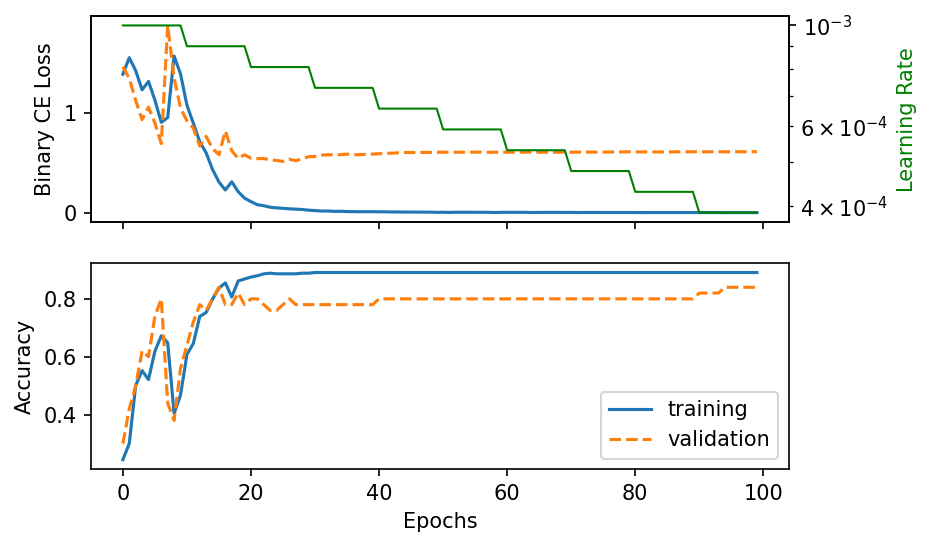

In [40]:
my_DNN = DeepNeuralNet_Swish(X_train.shape,
                             NUM_CLASSES,
                             batch_size=BATCHSIZE,
                             init_lr=LEARNING_RATE,
                             lr_scheduler=lr_step_decay,
                             )

history = my_DNN.fit(X_train, Y_train,
                     X_validation, Y_validation, 
                     NUM_EPOCHS
                     )

plot_history(history)

Learning rate schedule: constant
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_step_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_inverse_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_exponential_decay
run 0

run 1

run 2

run 3

run 4



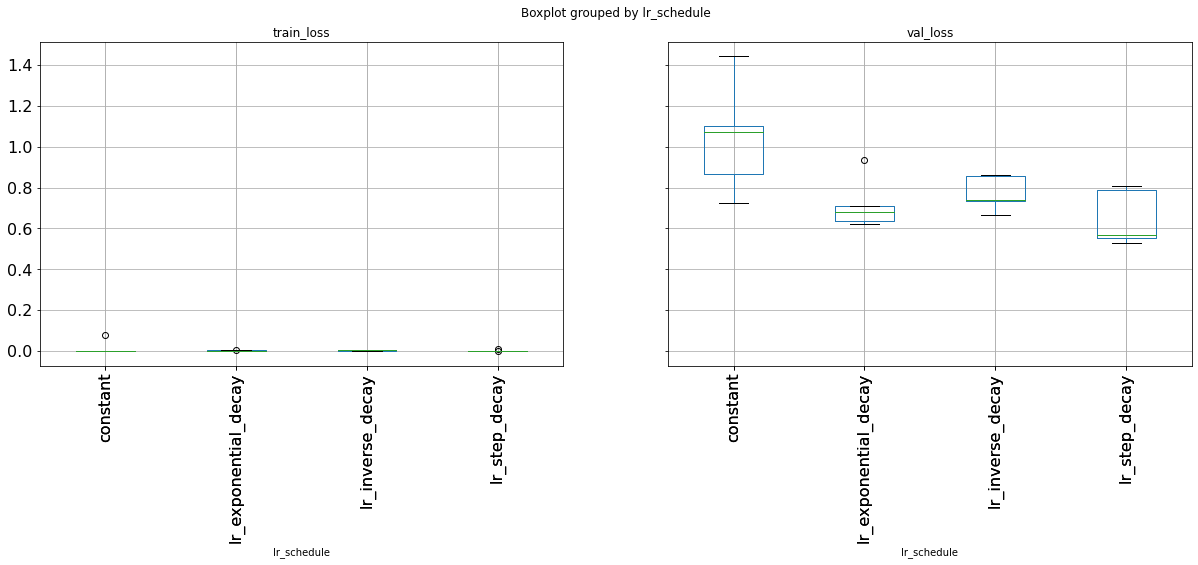

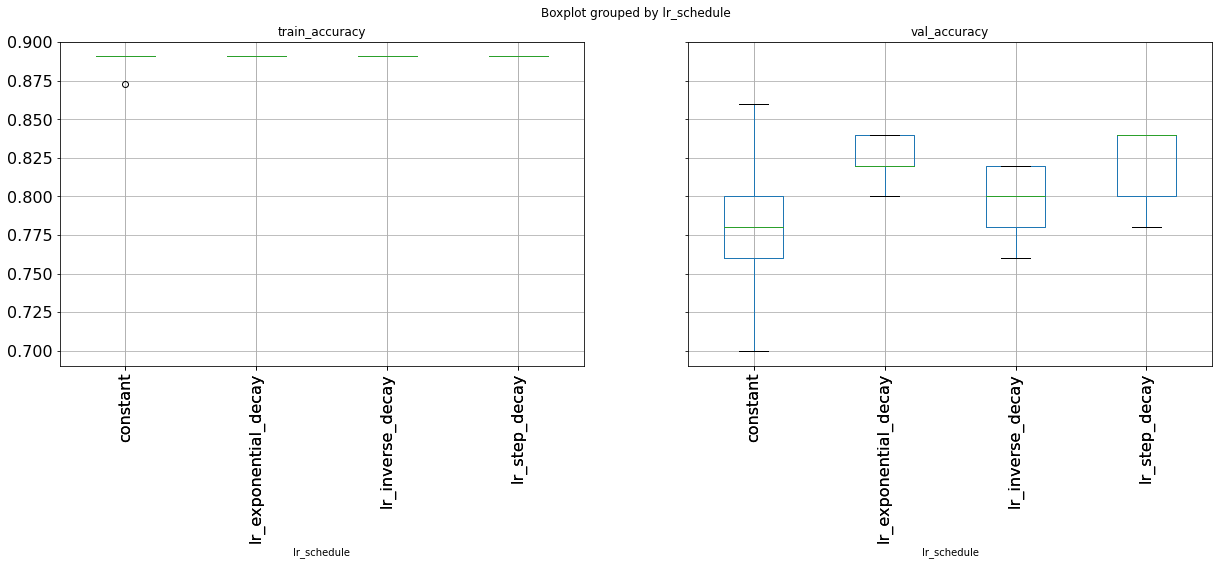

In [41]:
#@title run experiments and plot results

import pandas as pd

results = pd.DataFrame(columns=['lr_schedule', 'repetition', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for lr_schedule in (None, lr_step_decay, lr_inverse_decay, lr_exponential_decay):
  print('Learning rate schedule:', lr_schedule.__name__ if lr_schedule else 'constant')
  for repetition in range(5):
    print('run', repetition)
    my_NN = DeepNeuralNet_Swish(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_schedule,
                  verbose=False
                  )
    history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)
    run_results = [lr_schedule.__name__ if lr_schedule else 'constant', 
                   repetition,
                   history['loss'][-1],
                   history['val_loss'][-1],
                   history['train_acc'][-1],
                   history['val_acc'][-1],
                   ]
    results.loc[len(results)] = run_results

axes = results.boxplot(column=['train_loss', 'val_loss'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

axes = results.boxplot(column=['train_accuracy', 'val_accuracy'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

***

# Congratulations on completing Assignment 1!

You've just coded your own neural networks in NumPy and trained them for recognizing classes of flowers in images. You learned 

- how to use one-hot encodings for representing categorical data, e.g., class labels,
- how to use the softmax function and cross-entropy loss for multi-class classification,
- that it is important to evaluate different learning rate schedules,
- how to compute forward and backward propagations in networks with more than one hidden layer,
- that sigmoid activations on non-centric data (we'll learn about that in two Labs) induce vanishing gradients,
- ReLU and Swish activation functions help mitigate vanishing gradients.

# Submission Instructions

You may now submit your notebook to moodle:
- Enter your email adress in the cell below.
- Click on '*Runtime*' -> '*Restart and run all*'.
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.

In [38]:
#@title Enter your email address, then run this cell:

email_address = 'roman.mysianov@tu-ilmenau.de' #@param {type:"string"}